# **Projet 6 : Classifiez automatiquement des biens de consommation**

# Notebook 2 : Analyse des données visuelles (Images)

# Sommaire:

**Objectif**

**<a href="#C1"> I) Fonctions de l'analyse (Clustering et Réduction de dimensions) </a>**


**<a href="#C2"> II) Chargement et aperçu des images</a>**

    
**<a href="#C3"> III) Creation de features et Clustering</a>**
- <a href="#C4"> 1) SIFT</a>
- <a href="#C5"> 2) VGG16 </a>
- <a href="#C6"> 3) VGG19 </a>
- <a href="#C7"> 4) Xception </a>
- <a href="#C8"> 5) Inception V3</a>
- <a href="#C9"> 6) Resnet</a>

**<a href="#C10">IV) Analyse du meilleur modèle</a>**

&nbsp;

***

# **Objectif**

**Contexte :**

L’ entreprise "Place de marché” souhaite lancer une marketplace e-commerce. Pour cela, les vendeurs doivent attribuer une catégorie manuellement à leurs produits à partir d’une description et d’une photo.  Afin de passer à une plus large échelle et faciliter le processus, il devient nécessaire d’automatiser cette tâche.
  
_


**Mission :** 

Réaliser une première étude de faisabilité d'un moteur de classification afin d'attribuer automatiquement la catégorie à un article :
- Analyse de données textuelles (description) + Clustering
- Analyse de données visuelles (image) + Clustering
&nbsp;

_


**Données :**

Export de la base de données contenant 1050 produits, leur description et leur image associées
&nbsp;

_


**Livrables :**

Afin de répondre à cette mission, trois notebook ont été réalisé : 
- Notebook 1 : Analyse des données textuelles (description) et clusterisation
- Notebook 2 : Analyse des données visuelles (images) et clusterisation
- Notebook 3 : Combinaison du meilleur modèle de texte et d'image et classification supervisée

***

In [1]:
# Import des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm

In [2]:
# Import du DF déjà clean

df = pd.read_csv("data_cleaned.csv")

# <a name="C1"> I) Fonctions de l'analyse (Clustering et Réduction de dimensions)</a>

In [3]:
import time
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD
from umap import UMAP
from sklearn.preprocessing import LabelEncoder


def select_n_components(features, goal_var: float) -> int:
    """ 
    La méthode PCA de sklearn permet de selectionner un float en n_compoents afin de ne garder que 0.99 (par ex) de la variance totale mais cela n'est pas possible pour la méthode SVD.
    Cette function permet de récupérer le nombre de composantes expliquant X%  de la variance totale par la méthode de réduction SVD. 
    """

    # Création et fit du modèle
    tsvd = TruncatedSVD(n_components=features.shape[1]-1)
    tsvd.fit(features)
    tsvd_var_ratios = tsvd.explained_variance_ratio_

    # Initialisation
    total_variance = 0.0
    n_components = 0

    # boucle pour avoir le nombre de composante expliquant goal_var variance :
    for explained_variance in tsvd_var_ratios:

        # somme de la variance expliquée par itération
        total_variance += explained_variance

        # Nb composantes +1 par itération
        n_components += 1

        # Si la variance totale > objectifs
        if total_variance >= goal_var:
            # Arrêt de la boucle
            break

    # Return the number of components
    return n_components

##########################################
##########################################

# Calcul Reduction, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters


def reduction_fct(features, reduc='SVD'):
    """ Cette fonction permet de réduire et clusteriser des données 
    avec le choix de l'algorithme de réduction dans les arguments : SVD, UMAP ou TSNE
    """

    if reduc == 'SVD':
        n_comp = select_n_components(features, goal_var=0.99)
        print(f"Number of dimensions before TSVD: {features.shape[1]}")
        print(
            f"Number of dimensions after TSVD (99% var. explained): {n_comp}")
        modelSVD = TruncatedSVD(n_components=n_comp, random_state=42)
        reduc_X = modelSVD.fit_transform(features)
        return reduc_X

    elif reduc == 'TSNE':
        tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
        reduc_X = tsne.fit_transform(features)
        return reduc_X

    elif reduc == 'UMAP':
        modelUMAP = UMAP(n_neighbors=200,
                         min_dist=1,
                         n_components=2,
                         random_state=42)
        reduc_X = modelUMAP.fit_transform(features)
        return reduc_X

    else:
        print("please select 'SVD' (PCA equivalent for sparse data),'TSNE' or 'UMAP'")

##########################################
##########################################


def kmeans_fct(features, y_categ):
    """ Fonction permettant de réaliser un kmeans et de calculer l'ARI entre les vrais labels et les labels prédits"""
    # Détermination des clusters à partir des données après Tsne
    num_labels = len(set(y_categ))
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    ARI = np.round(adjusted_rand_score(y_categ, cls.labels_), 4)
    print("ARI : ", ARI)

    return ARI, cls.labels_


##########################################
##########################################

def reduc_visu_fct(reduc_X, target, labels):
    """visualisation des axes réduits (2 premiers) selon les vraies catégories et selon les clusters"""
    # Encodage des targets pour la couleur des clusters
    LE = LabelEncoder()
    y_categ = LE.fit_transform(target)
    categ = list(set(target))

    # représentation graphique
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=y_categ, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=categ, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()

# <a name="C2"> II) Chargement et aperçu des images</a>

In [4]:
# Chargement de la liste des images

from os import listdir

path = "data/Flipkart/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [5]:
#data_photo = pd.DataFrame(list_photos, columns = ['photo_id'])
# data_photo = pd.merge(df[['image','Categ_A']],data_photo,
#                      right_on='photo_id',
#                      left_on='image').drop(columns=['image'])

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df["label"] = le.fit_transform(df["Categ_A"])

Home Decor & Festive Needs 


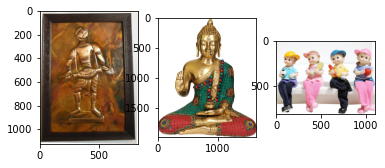

Watches 


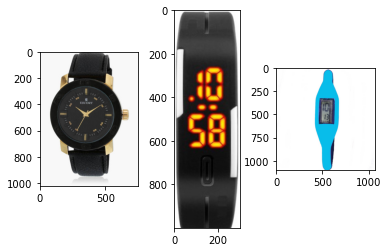

Kitchen & Dining 


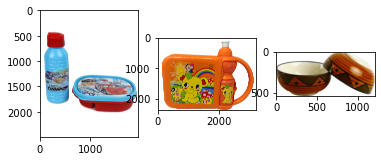

Beauty and Personal Care 


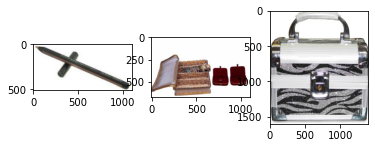

Computers 


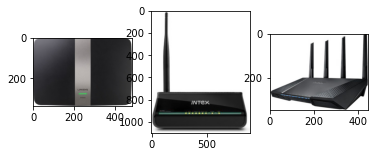

Home Furnishing 


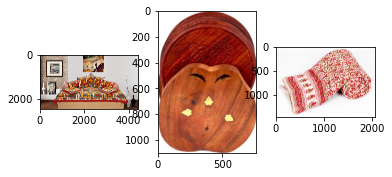

Baby Care 


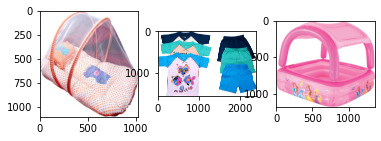

In [7]:
# Représentation d'un échantillons d'image par catégorie
from matplotlib.image import imread


def list_fct(name):
    list_image_name = [df["image"][i]
                       for i in range(len(df)) if df["Categ_A"][i] == name]
    return list_image_name


for categ in list(set(df['Categ_A'])):
    globals()[f'list_{categ}'] = [df["image"][i]
                                  for i in range(len(df)) if df["Categ_A"][i] == categ]

for name in list(set(df['Categ_A'])):
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [8]:
# Initialisation d'une liste vide pour les résultats d'ARI :

ARI_results = np.empty(shape=[0, 3])

# <a name="C3"> III) Creation de features et Clustering</a>

## <a name="C4"> 1) SIFT</a>

### a) Exemple de Descripteurs sur un article

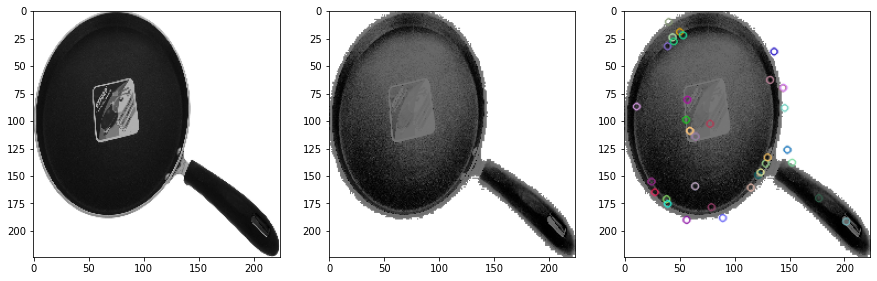

In [9]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()

image = cv2.imread(path+list_photos[1], 0)  # convert in gray
image = cv2.resize(image, (224, 224))
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(image, cmap='gray')


image = cv2.equalizeHist(image)   # equalize image histogram

plt.subplot(132)
plt.imshow(image, cmap='gray')

kp, des = sift.detectAndCompute(image, None)
image = cv2.drawKeypoints(image, kp, image)

plt.subplot(133)
plt.imshow(image, cmap='gray')
plt.show()

In [10]:
len(df["image"])

1050

### b) Création des descripteurs

In [11]:
import time
import cv2

from PIL import Image
import warnings
warnings.simplefilter('ignore', Image.DecompressionBombWarning)


sift_keypoints = []
temps1 = time.time()
sift = cv2.xfeatures2d.SIFT_create()

for image_num in tqdm(range(len(df["image"]))):
   #if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+df["image"][image_num], 0)  # convert in gray
    image = cv2.resize(image, (299, 299))
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1 = time.time()-temps1
print("temps de traitement SIFT descriptor : ",
      "%15.2f" % duration1, "secondes")

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:30<00:00, 34.92it/s]


Nombre de descripteurs :  (550949, 128)
temps de traitement SIFT descriptor :            30.13 secondes



C:\Users\ClementD\AppData\Local\Temp\ipykernel_8976\3062057318.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


### c) Clustering des descripteurs

In [12]:
# Création des clusters de descripteurs
#  Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables
from sklearn import cluster, metrics


# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1 = time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  742
Création de 742 clusters de descripteurs ...


C:\Users\ClementD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


temps de traitement kmeans :            12.36 secondes


### d) Création des histogrammes

In [13]:
# Creation of histograms
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms (features)
temps1 = time.time()

hist_vectors = []

for i, image_desc in enumerate(tqdm(sift_keypoints_by_img)):
    #if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [01:19<00:00, 13.24it/s]

temps de création histogrammes :            79.30 secondes


### e) Clustering

In [14]:
# kmeans

ARI, labels = kmeans_fct(im_features, df['Categ_A'])

ARI_results = np.append(ARI_results, [["SIFT", "None", ARI]], axis=0)

ARI :  0.0268


In [15]:
# PCA + kmeans

from sklearn.decomposition import PCA
pca = PCA(n_components=.99, random_state=22)
pca.fit(im_features)
x = pca.transform(im_features)

print(f"Components before PCA: {im_features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, df['Categ_A'])

ARI_results = np.append(ARI_results, [["SIFT", "PCA", ARI]], axis=0)

Components before PCA: 742
Components after PCA: 553
ARI :  0.0228


ARI :  0.0512


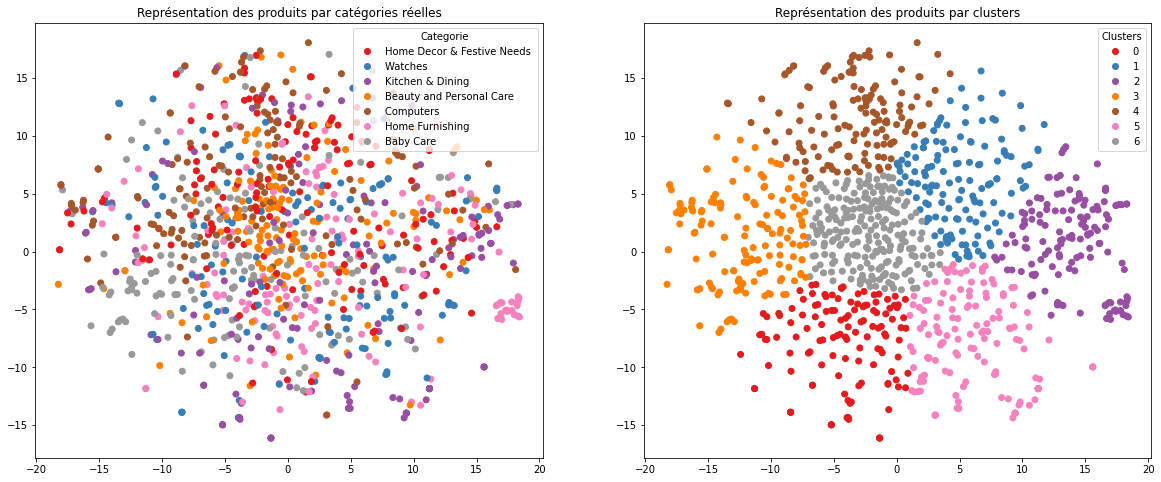

In [16]:
# TSNE + kmeans
X_reduc = reduction_fct(im_features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["SIFT", "TSNE", ARI]], axis=0)

ARI :  0.0383


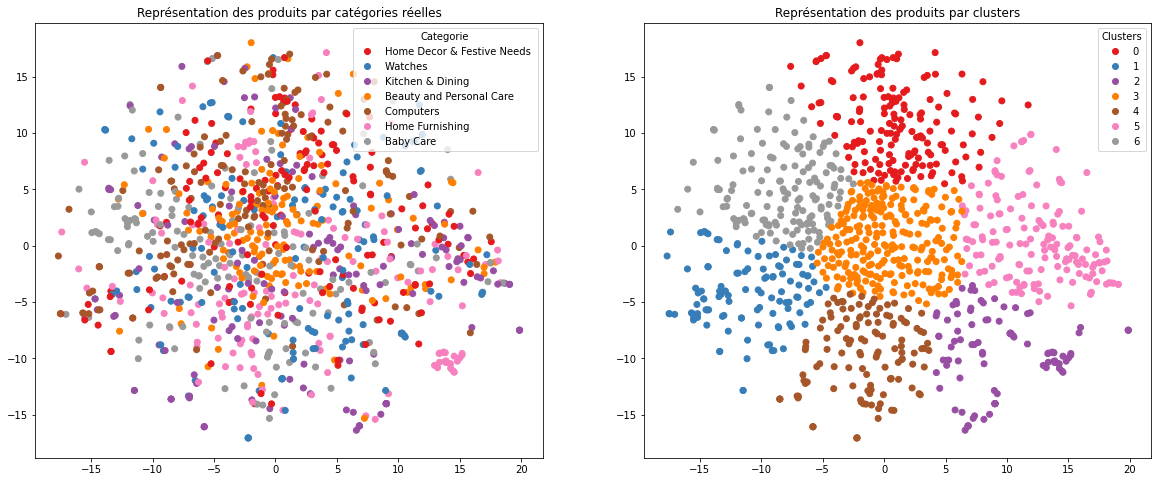

In [17]:
# PCA + TSNE + kmeans

X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["SIFT", "PCA-TSNE", ARI]], axis=0)

## <a name="C5"> 2) VGG16 </a>

In [18]:
# Présentation du modèle

from keras.applications import VGG16


VGG16_model = VGG16(
    include_top=True,
    weights="imagenet",
)

VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# Chargement des images et pre-processing spécifique

from keras.applications import vgg16
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

from PIL import Image, ImageOps
import warnings
warnings.simplefilter('ignore', Image.DecompressionBombWarning)


X = []
for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(path+df["image"][image_num], target_size=(224, 224))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = vgg16.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:22<00:00, 45.70it/s]


In [20]:
# Utilisation du modèle pour générer les features

from keras.models import Model

VGG16_model = VGG16()

VGG16_model = Model(inputs=VGG16_model.inputs,
                    outputs=VGG16_model.layers[-2].output)

features = VGG16_model.predict(X, use_multiprocessing=True)

33/33 [==============================] - 138s 4s/step


In [21]:
# kmeans

ARI, labels = kmeans_fct(features, df['Categ_A'])

ARI_results = np.append(ARI_results, [["VGG16", "None", ARI]], axis=0)

ARI :  0.3704


In [22]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, df['Categ_A'])

ARI_results = np.append(ARI_results, [["VGG16", "PCA", ARI]], axis=0)

Components before PCA: 4096
Components after PCA: 824
ARI :  0.3792


ARI :  0.4758


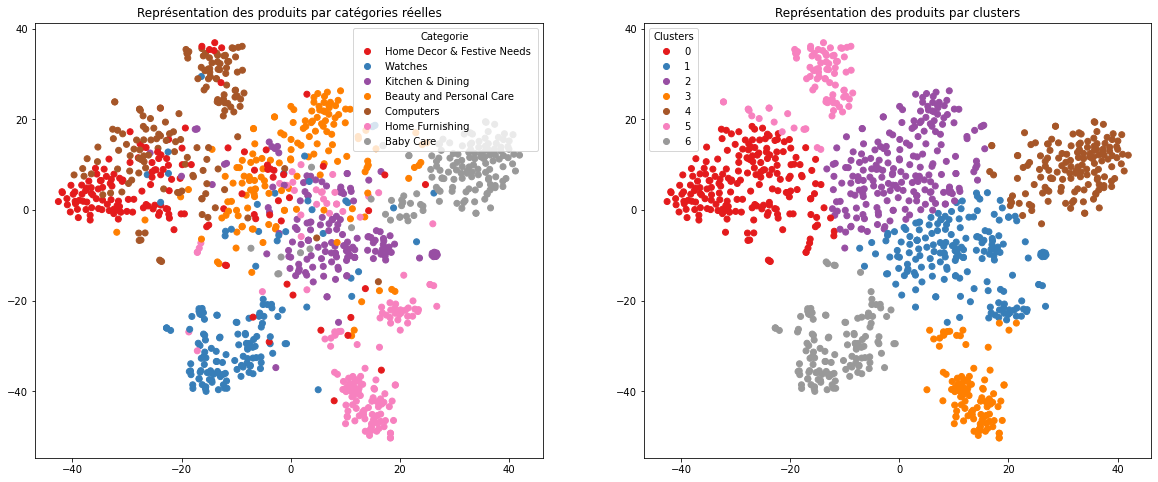

In [23]:
# TSNE + kmeans

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["VGG16", "TSNE", ARI]], axis=0)

ARI :  0.4854


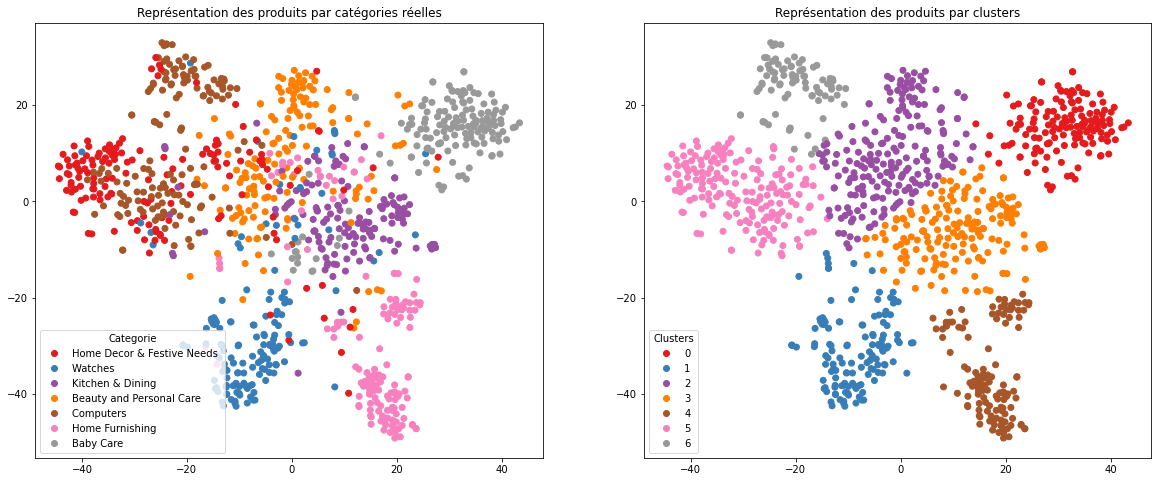

In [24]:
# PCA + TSNE + kmeans

X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["VGG16", "PCA-TSNE", ARI]], axis=0)

## <a name="C6"> 3) VGG19</a>

In [25]:
# Présentation du modèle

from keras.applications import VGG19


VGG19_model = VGG19(
    include_top=True,
    weights="imagenet",
)

VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
# Chargement des images et pre-processing spécifique

from keras.applications import vgg19


X = []
for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(path+df["image"][image_num], target_size=(224, 224))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = vgg19.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:22<00:00, 46.07it/s]


In [27]:
# Utilisation du modèle pour générer les features

VGG19_model = VGG19()

VGG19_model = Model(inputs=VGG19_model.inputs,
                    outputs=VGG19_model.layers[-2].output)

features = VGG19_model.predict(X, use_multiprocessing=True)

33/33 [==============================] - 184s 6s/step


In [28]:
# kmeans

ARI, labels = kmeans_fct(features, df['Categ_A'])

ARI_results = np.append(ARI_results, [["VGG19", "None", ARI]], axis=0)

ARI :  0.3722


In [29]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, df['Categ_A'])

ARI_results = np.append(ARI_results, [["VGG19", "PCA", ARI]], axis=0)

Components before PCA: 4096
Components after PCA: 819
ARI :  0.37


ARI :  0.4931


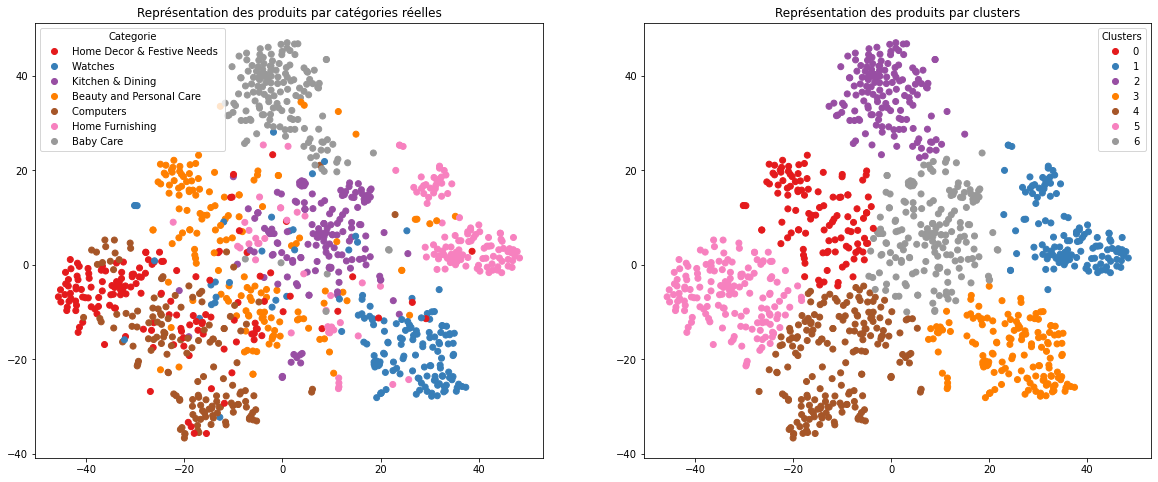

In [30]:
# TSNE + kmeans

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["VGG19", "TSNE", ARI]], axis=0)

ARI :  0.5149


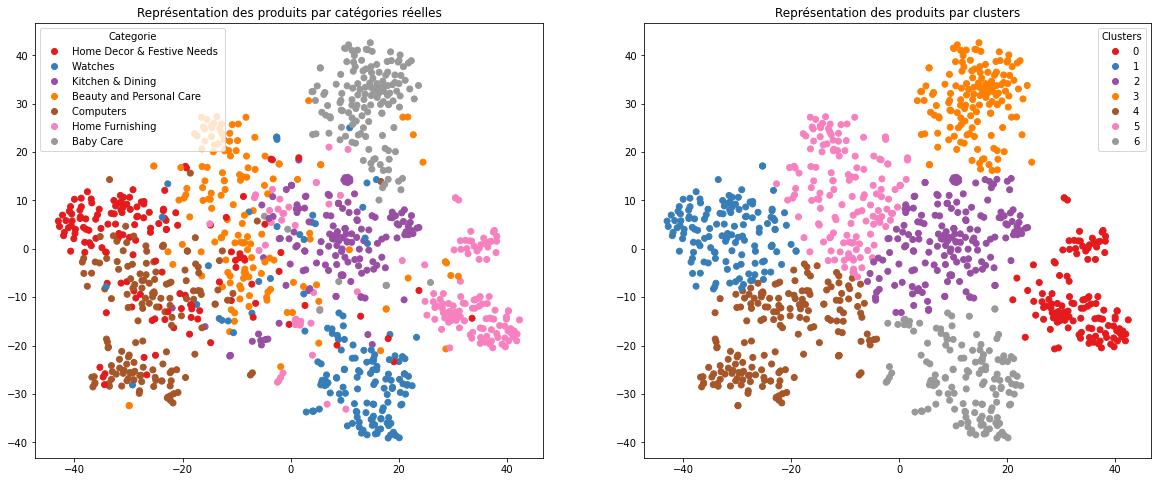

In [31]:
# PCA + TSNE + kmeans

X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["VGG19", "PCA-TSNE", ARI]], axis=0)

## <a name="C7"> 4) Xception</a>

In [32]:
# Présentation du modèle

from keras.applications import Xception

xception_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(299, 299, 3),
    pooling='avg'
)
xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [33]:
# Chargement des images et pre-processing spécifique
from keras.applications import xception

X = []

for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(path+df["image"][image_num], target_size=(299, 299))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(299, 299, 3)
    imgx = xception.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:23<00:00, 44.64it/s]


In [34]:
# Utilisation du modèle pour générer les features

features = xception_model.predict(X, use_multiprocessing=True)

33/33 [==============================] - 105s 3s/step


In [35]:
# kmeans

ARI, labels = kmeans_fct(features, df['Categ_A'])

ARI_results = np.append(ARI_results, [["Xception", "None", ARI]], axis=0)

ARI :  0.463


In [36]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, df['Categ_A'])

ARI_results = np.append(ARI_results, [["Xception", "PCA", ARI]], axis=0)

Components before PCA: 2048
Components after PCA: 759
ARI :  0.4634


ARI :  0.497


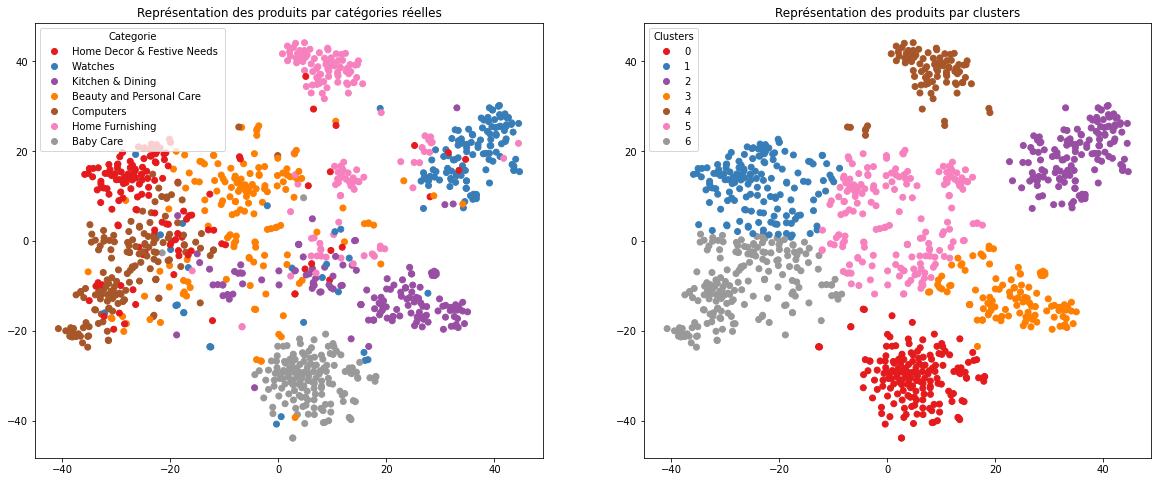

In [37]:
# TSNE + kmeans

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["Xception", "TSNE", ARI]], axis=0)

ARI :  0.5318


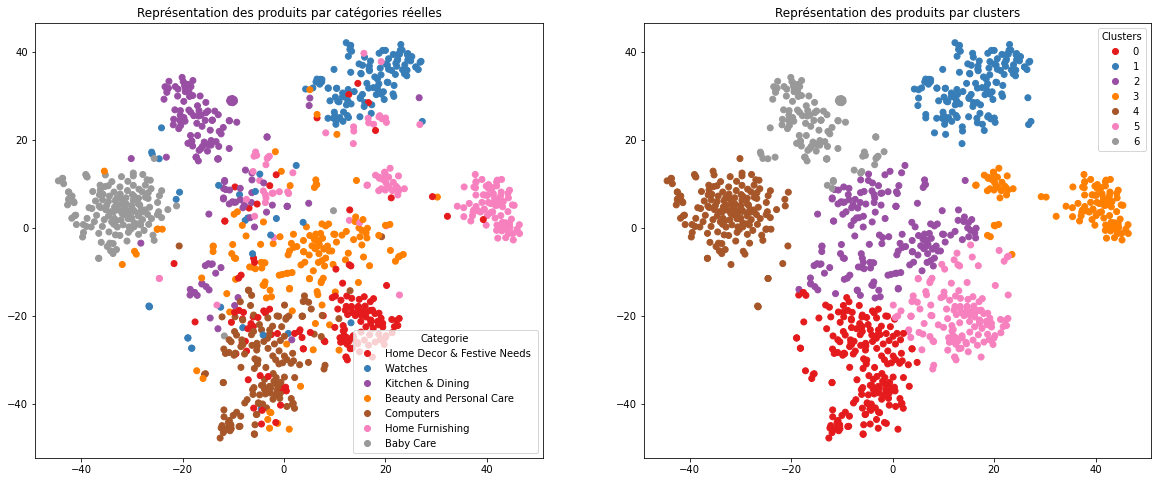

In [38]:
# PCA + TSNE + kmeans
X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["Xception", "PCA-TSNE", ARI]], axis=0)

## <a name="C8"> 5) Inception v3</a>

In [39]:
# Présentation du modèle

from keras.applications import InceptionV3

model_incep = InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False,
    pooling='avg'
)
model_incep.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 149, 149, 32  96         ['conv2d_4[0][0]']               
 rmalization)                   )                                                      

 batch_normalization_9 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 64)  192         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_14 (BatchN  (None, 35, 35, 96)  288         ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_15 (BatchN  (None, 35, 35, 32)  96          ['conv2d_15[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_26 (BatchN  (None, 35, 35, 64)  192         ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_27 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_38 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_38 (BatchN  (None, 17, 17, 128)  384        ['conv2d_38[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_48 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_48 (BatchN  (None, 17, 17, 160)  480        ['conv2d_48[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_48[0][0]'] 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_59 (BatchN  (None, 17, 17, 160)  480        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_59[0][0]'] 
          

                                                                                                  
 batch_normalization_69 (BatchN  (None, 17, 17, 192)  576        ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_69[0][0]'] 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_78 (BatchN  (None, 17, 17, 192)  576        ['conv2d_78[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_80 (BatchN  (None, 8, 8, 320)   960         ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_86[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_87[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_95[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_96[0][0]'] 
                                                                                                  
 batch_normalization_97 (BatchN  (None, 8, 8, 192)   576         ['conv2d_97[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_89[0][0]'] 
                                                                                                  
 mixed9_1 

In [40]:
# Chargement des images et pre-processing spécifique

from keras.applications import inception_v3


X = []

for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(path+df["image"][image_num], target_size=(299, 299))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(299, 299, 3)
    imgx = inception_v3.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

# Création des features

features = model_incep.predict(X, use_multiprocessing=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:23<00:00, 45.08it/s]


33/33 [==============================] - 61s 2s/step


In [41]:
# kmeans
ARI, labels = kmeans_fct(features, df['Categ_A'])

ARI_results = np.append(ARI_results, [["InceptionV3", "None", ARI]], axis=0)

ARI :  0.428


In [42]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, df['Categ_A'])

ARI_results = np.append(ARI_results, [["InceptionV3", "PCA", ARI]], axis=0)

Components before PCA: 2048
Components after PCA: 704
ARI :  0.4273


ARI :  0.5475


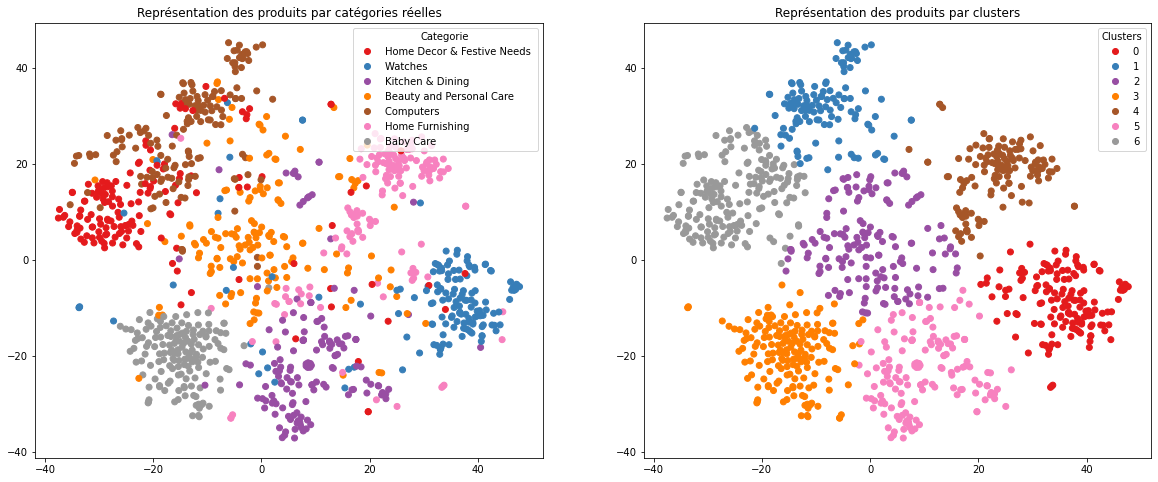

In [43]:
# TSNE + kmeans

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["InceptionV3", "TSNE", ARI]], axis=0)

ARI :  0.5467


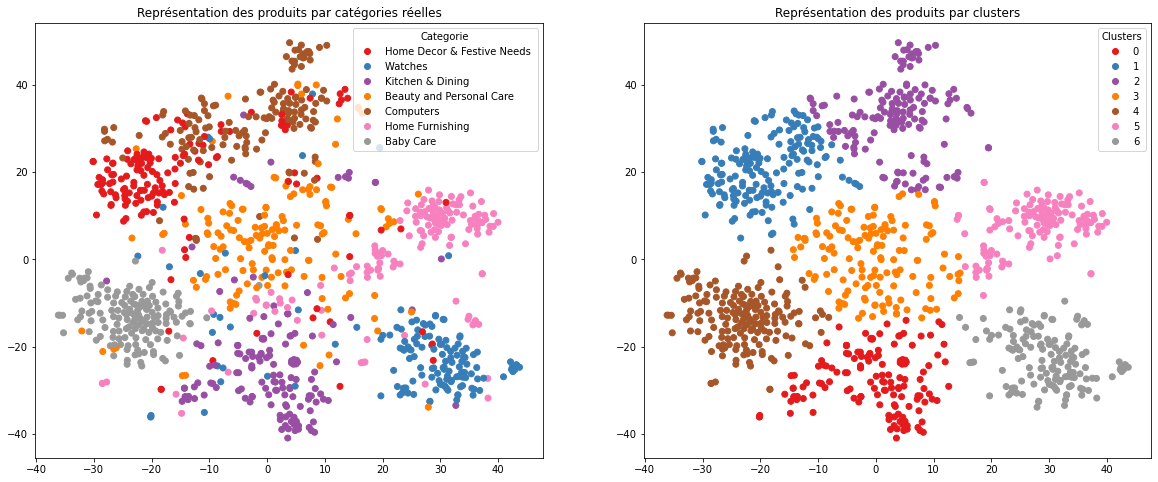

In [44]:
# PCA + TSNE + kmeans

X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(
    ARI_results, [["InceptionV3", "PCA-TSNE", ARI]], axis=0)

## <a name="C9"> 6) ResNet</a>

In [45]:
# Présentation du modèle

from keras.applications import ResNet50

ResNet_model = ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg'
)
ResNet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [46]:
# Chargement des images et pre-processing spécifique

from keras.applications import resnet


X = []
for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(path+df["image"][image_num], target_size=(224, 224))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = resnet.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:22<00:00, 46.79it/s]


In [47]:
# Génération des features

features = ResNet_model.predict(X, use_multiprocessing=True)

33/33 [==============================] - 55s 2s/step


In [48]:
# kmeans

ARI, labels = kmeans_fct(features, df['Categ_A'])

ARI_results = np.append(ARI_results, [["ResNet", "None", ARI]], axis=0)

ARI :  0.4029


In [49]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, df['Categ_A'])

ARI_results = np.append(ARI_results, [["ResNet", "PCA", ARI]], axis=0)

Components before PCA: 2048
Components after PCA: 731
ARI :  0.3988


ARI :  0.5152


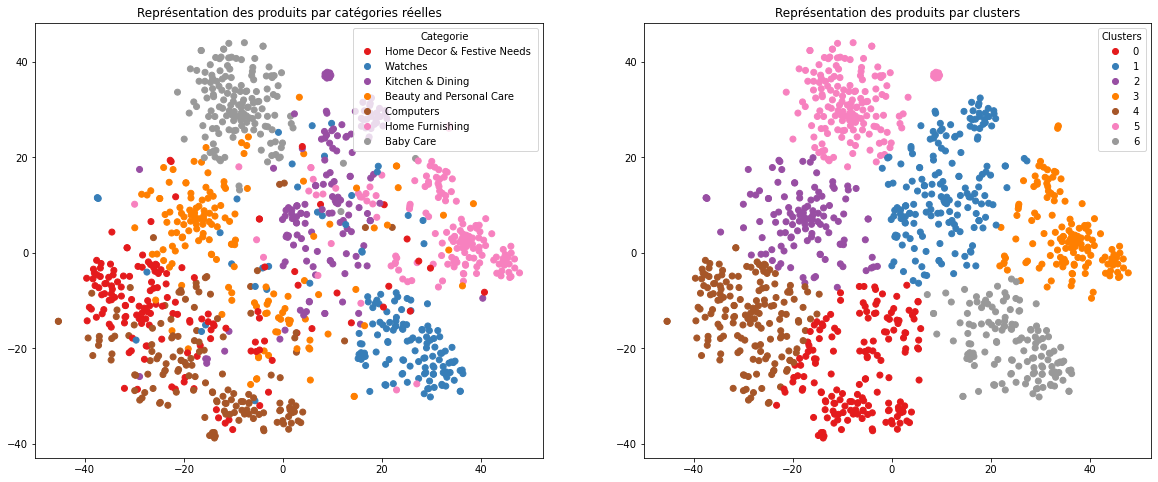

In [50]:
# TSNE + kmeans
X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["ResNet", "TSNE", ARI]], axis=0)

ARI :  0.5054


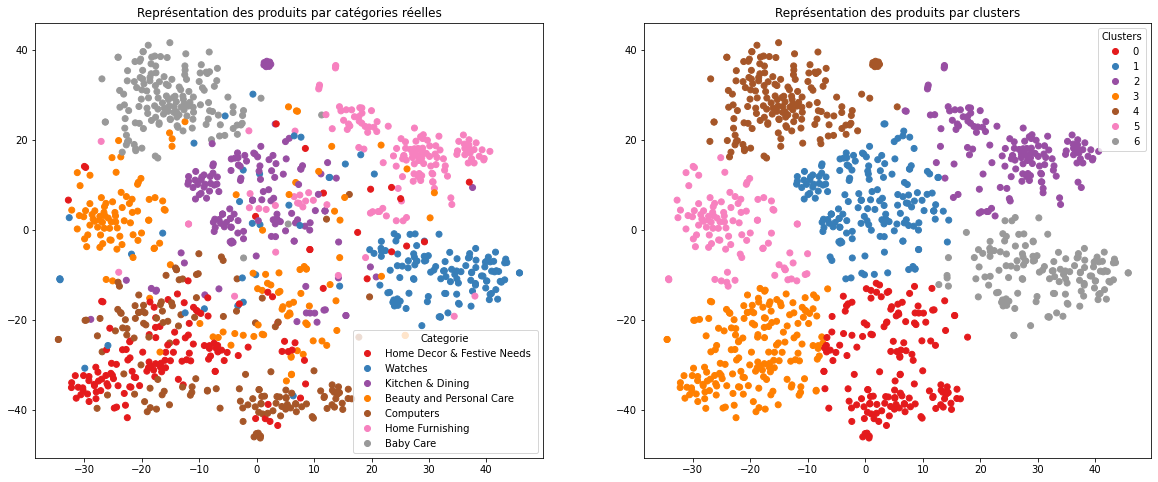

In [51]:
# PCA + TSNE + kmeans

X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["ResNet", "PCA-TSNE", ARI]], axis=0)

# <a name="C10"> IV) Analyse du meilleur modèle</a>

In [52]:
# Génération du DF de l'ARI
ARI_results_df = pd.DataFrame(
    ARI_results, columns=["model", "reduction", "ARI"])
ARI_results_df['ARI'] = ARI_results_df['ARI'].astype(float)

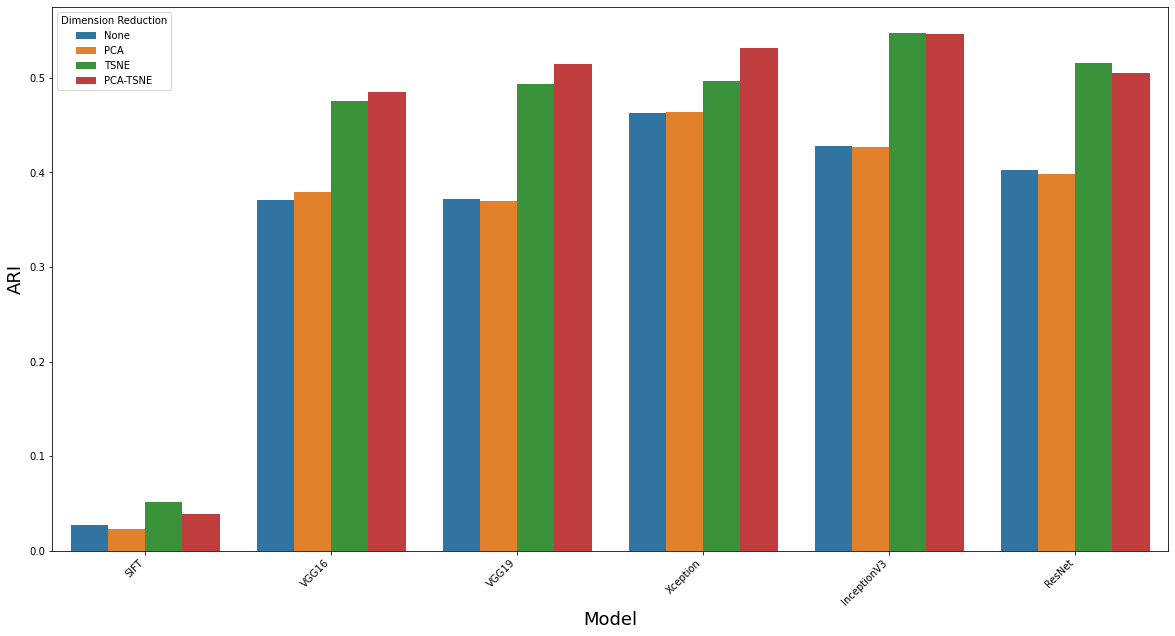

In [53]:
# Représentation graphique

plt.figure(figsize=(20, 10))

sns.barplot(data=ARI_results_df, x="model", y="ARI", hue="reduction")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dimension Reduction')
plt.xlabel('Model', fontsize=18)
plt.ylabel('ARI', fontsize=18)

plt.show()

In [54]:
# Recréation des features du meilleur modèle
X = []

for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(path+df["image"][image_num], target_size=(299, 299))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(299, 299, 3)
    imgx = inception_v3.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)


features = model_incep.predict(X, use_multiprocessing=True)

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:23<00:00, 45.44it/s]


33/33 [==============================] - 58s 2s/step
ARI :  0.5475


In [55]:
# Encodage des catégories

LE = LabelEncoder()
y_categ = LE.fit_transform(df['Categ_A'])

In [56]:
# Matrice de confusion

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_categ, labels)

In [57]:
cm

array([[  5,  12,   9,   2,   5,   5, 112],
       [121,   4,   6,   6,   1,   9,   3],
       [  2,   2,  15,   3,   3, 125,   0],
       [  6,  17,  96,   7,  12,   5,   7],
       [  0,  84,  10,   0,   0,   0,  56],
       [ 16,   1,  16,   4, 106,   7,   0],
       [  0,   0,   1, 149,   0,   0,   0]], dtype=int64)

In [58]:
# réarrangement des clusters pour plus de visibilité (par l'algorithme Hungarian)

from scipy.optimize import linear_sum_assignment as linear_assignment


def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)


indexes = linear_assignment(_make_cost_m(cm))
indexes = np.array(list(zip(*indexes)))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

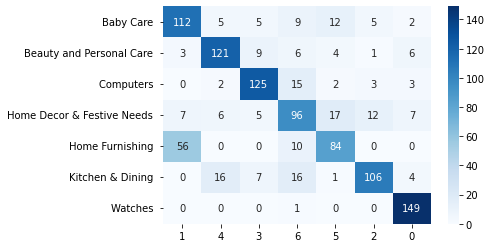

In [59]:
# représentation graphique

df_cm = pd.DataFrame(cm2, index=[label for label in list(np.unique(df["Categ_A"]))],
                     columns=[i for i in list(np.argmax(cm, axis=0))])
ax = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")